# Package

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
import statsmodels.api as sm
from sklearn.metrics import recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# IMPORT

In [2]:
# Chemins des fichiers Excel

chemin_train = r'C:\Users\loren\Desktop\Data_challenge\data\df_train.xlsx'
chemin_test = r'C:\Users\loren\Desktop\Data_challenge\data\df_test.xlsx'

df_train = pd.read_excel(chemin_train)
df_test = pd.read_excel(chemin_test)

In [3]:
# Verification 

print(df_train.dtypes)

ID_t                            int64
Nb_of_incident                  int64
Electrical_length             float64
Service_date                    int64
Length_climate_hazard_plan    float64
Length_fragile_section        float64
Nb_of_anomaly                   int64
dtype: object


# LOGISTIQUE

In [4]:
# Séparation cible

X_train = df_train.drop(['Nb_of_incident', 'ID_t'], axis=1)
y_train = df_train['Nb_of_incident']

X_test = df_test.drop(['Nb_of_incident','ID_t'], axis=1)
y_test = df_test['Nb_of_incident']

In [5]:
# Modèle

# Instancier et entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

In [6]:
# Affichage des coefficients
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
for feature, coef in zip(X_test.columns, coefficients[0]):
    print(f"{feature}: {coef}")

print("\nIntercept:", intercept)

# Calcul des rapports de cotes
odds_ratios = [round(pow(2, coef), 4) for coef in coefficients[0]]

print("\nRapports de cotes:")
for feature, odds_ratio in zip(X_test.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")

Coefficients:
Electrical_length: 0.00023566682906105485
Service_date: 0.020382685931782107
Length_climate_hazard_plan: 0.07369053261547721
Length_fragile_section: 0.03287440460787279
Nb_of_anomaly: -0.002171460859340782

Intercept: [-4.28160281]

Rapports de cotes:
Electrical_length: 1.0002
Service_date: 1.0142
Length_climate_hazard_plan: 1.0524
Length_fragile_section: 1.023
Nb_of_anomaly: 0.9985


# Resultats détaillés

In [7]:
# Ajouter une constante à la matrice X_train pour l'intercept
X_train_with_const = sm.add_constant(X_train)

# Instancier et entraîner le modèle avec statsmodels
model_sm = sm.Logit(y_train, X_train_with_const)
result = model_sm.fit()

# Affichage des résultats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.183770
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         Nb_of_incident   No. Observations:                49645
Model:                          Logit   Df Residuals:                    49639
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Jan 2024   Pseudo R-squ.:                 0.03089
Time:                        11:00:53   Log-Likelihood:                -9123.3
converged:                       True   LL-Null:                       -9414.0
Covariance Type:            nonrobust   LLR p-value:                2.001e-123
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.2817      0.089    -48.263      0.000      

# Cut-off optimal

In [8]:
# Avoir les probabilités afin de choisir le cut-off de notre choix

y_proba= model.predict_proba(X_test)[:, 1]

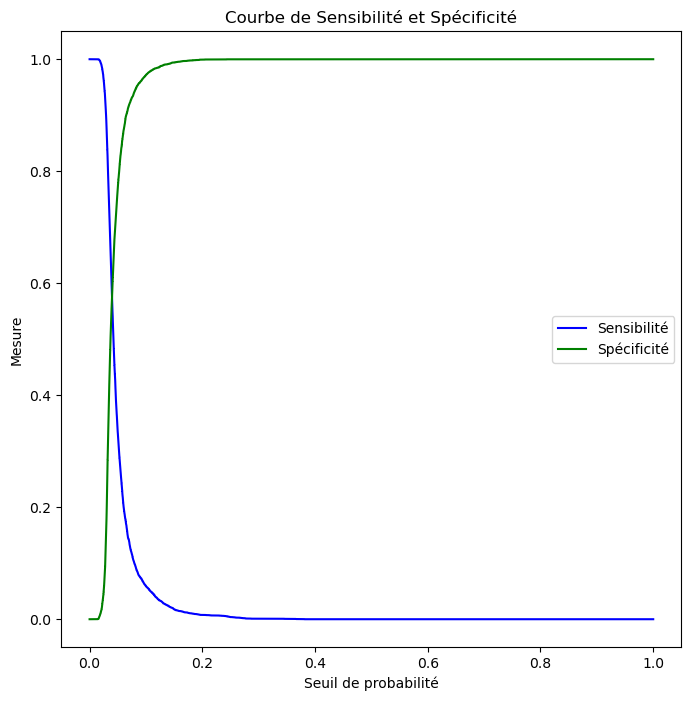

In [9]:
# Optimisation 

thresholds = np.arange(0, 1.00, 0.00001)

# Calculer la sensibilité et la spécificité pour différents seuils
sensitivities = []
specificities = []

for threshold in thresholds:
    # Convertir les probabilités en prédictions binaires en utilisant le seuil actuel
    y_pred = (y_proba > threshold).astype(int)
    
    # Calculer la matrice de confusion
    confusion = confusion_matrix(y_test, y_pred)
    
    # Extraire les éléments de la matrice de confusion
    tn, fp, fn, tp = confusion.ravel()
    
    # Calculer la sensibilité et la spécificité
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Stocker les résultats
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Tracer la courbe de la sensibilité et de la spécificité
plt.figure(figsize=(8, 8))
plt.plot(thresholds, sensitivities, label='Sensibilité', color='blue')
plt.plot(thresholds, specificities, label='Spécificité', color='green')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Mesure')
plt.title('Courbe de Sensibilité et Spécificité')
plt.legend()
plt.show()

In [10]:
# Trouver l'indice où les deux courbes se croisent
cross_index = np.argmin(np.abs(np.array(sensitivities) - np.array(specificities)))

# Récupérer la probabilité associée à cet indice
optimal_threshold = thresholds[cross_index]

# Afficher la probabilité optimale
print(f"Seuil de probabilité optimal : {optimal_threshold:.6f}")

Seuil de probabilité optimal : 0.039770


In [11]:
threshold = 0.039770
y_pred = (y_proba > threshold).astype(int)

In [12]:
confusion = confusion_matrix(y_test, y_pred)

# Extraction du nombre de vrais positifs (1 bien prédits) et de vrais négatifs (0 bien prédits)
vp_1 = confusion[1, 1]  # Vrais positifs pour la classe 1
vn_0 = confusion[0, 0]  # Vrais négatifs pour la classe 0

# Nombre réel de 1 (modalité 1 de la variable cible)
real_count_1 = sum(y_test == 1)
# Nombre réel de 0 (modalité 0 de la variable cible)
real_count_0 = sum(y_test == 0)

# Taux de vrais positifs (TPR) pour la classe 1
true_positive_rate_1 = round((vp_1 / real_count_1) * 100, 3)

# Taux de vrais négatifs (TNR) pour la classe 0
true_negative_rate_0 = round((vn_0 / real_count_0) * 100, 3)

print(f"Taux de vrais positifs (TPR) pour la classe 1 : {true_positive_rate_1}%")
print(f"Taux de vrais négatifs (TNR) pour la classe 0 : {true_negative_rate_0}%")

Taux de vrais positifs (TPR) pour la classe 1 : 57.329%
Taux de vrais négatifs (TNR) pour la classe 0 : 57.371%


In [13]:
confusion

array([[3522, 2617],
       [2652, 3563]], dtype=int64)

# Performances

In [14]:
# AUC

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5949578660207211


In [15]:
# Recall
recall_class1 = recall_score(y_test, y_pred)

print(f"Rappel (Recall) pour la classe 1 : {recall_class1:.4f}")

Rappel (Recall) pour la classe 1 : 0.5733


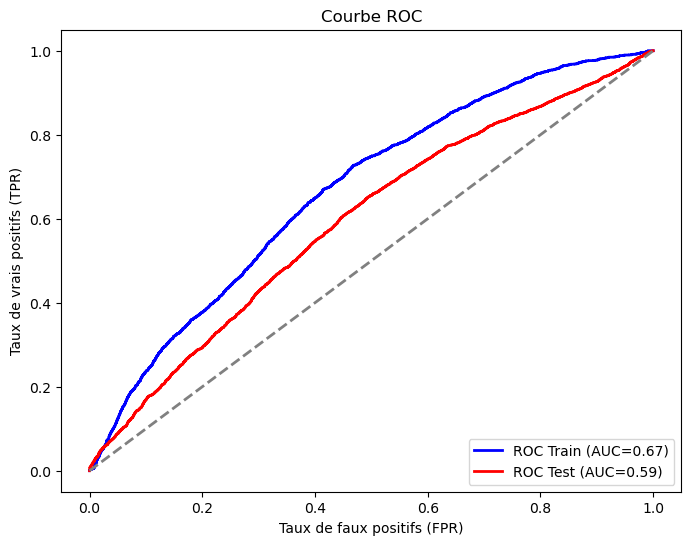

In [16]:
# GRAPH AUC

# Supposons que y_proba_train et y_proba_test sont les probabilités prédites pour la classe 1
y_proba_train = model.predict_proba(X_train)[:, 1]
y_proba_test = model.predict_proba(X_test)[:, 1]

# Calcul des FPR (taux de faux positifs) et TPR (taux de vrais positifs) pour les ensembles d'entraînement et de test
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

# Calcul des AUC pour les ensembles d'entraînement et de test
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC Train (AUC={auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC Test (AUC={auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()